# Make mock IFU datacubes for stellar population and kinematic modelling

Basic demo for how to create a three component galaxy. Full docs coming soon.

## Get SSP templates and an IFU-cube

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import popkinmocks as pkm

In [2]:
ssps = pkm.model_grids.milesSSPs()
cube = pkm.ifu_cube.IFUCube(ssps=ssps, nx1=25, nx2=26, nv=51, vrng=(-1000,1000))

In [3]:
cube.get_variable_size('t')

53

## Create a disk component

Next create a disk component,

In [4]:
disk1 = pkm.components.GrowingDisk(cube=cube, rotation=0., center=(0,0))

In [7]:
disk1.set_sig_v(
  q_lims=(0.5, 0.1),
  alpha_lims=(1.8, 1.8),
  sig_v_in_lims=(40., 200.),
  sig_v_out_lims=(20., 90.))

/Users/prash/Astro/Software/popkinmocks/popkinmocks/components/growing_disk.py:225: RuntimeWarning: invalid value encountered in power
  sigma = sig_v_in + (delta_sigma * rr/max_abs_x1)**alpha


In [9]:
%debug

> /Users/prash/Astro/Software/popkinmocks/popkinmocks/components/parametric.py(79)linear_interpolate_t()
     77         t = self.cube.ssps.par_cents[1]
     78         delta_f = f_start - f_end
---> 79         t_from_start = t - self.t_pars['t_start']
     80         f = f_end + delta_f/self.t_pars['delta_t'] * t_from_start
     81         f[t < self.t_pars['t_start']] = f_end

ipdb> exit


In [ ]:
q = 0.6
rr2 = disk1.xxp**2 + (disk1.yyp/q)**2
rr = rr2**0.5

In [ ]:
cube.imshow(rr/np.max(np.abs(disk1.xxp)))

### Star formation history

Specify the star formation history of the disk as a beta distribution with mean `0<phi<1` and concentration `lmd`,

<AxesSubplot:xlabel='$t$ [Gyr]'>

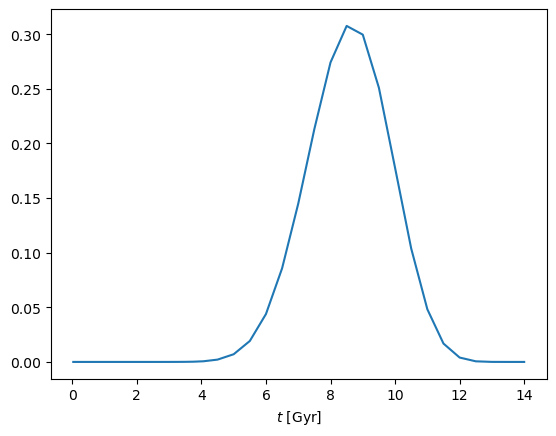

In [46]:
disk1.set_p_t(lmd=30., phi=0.6)
cube.plot('t', disk1.get_p('t'))

### Age-dependent spatial density

Set the age dependent spatial-density. These are cored, flattened power law profiles. Specifically,

$$
p(\vect{x}|t) \propto (r_q + r_c(t))^{-\alpha(t)}
$$

where elliptical radius

$$
r_q^2 = x^2 + \left(\frac{y}{q(t)}\right)^2
$$

and $r_c(t)$ is core length, $\alpha(t)$ is power law slope and $q(t)$ the flattening. All three parameters vary with age, and are specified as pairs of values for (young, old) stars. For intermediate ages the parameter is linearly interpolated.

(25, 26, 53)


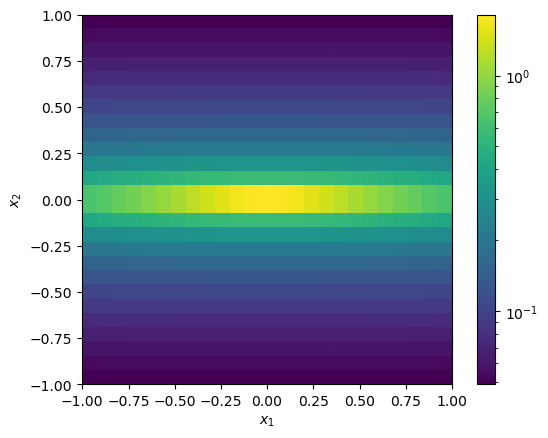

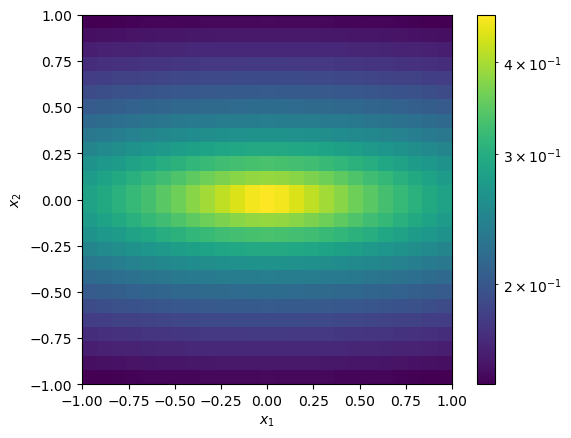

In [36]:
disk1.set_p_x_t(q_lims=(0.1, 0.3),
                rc_lims=(0.1, 0.9),
                alpha_lims=(1.2, 0.8))

p_x_t = disk1.get_p('x_t')
print(p_x_t.shape)

# plot surface density for youngest stars
cube.imshow(p_x_t[:,:,0], norm=LogNorm())
plt.show()

# plot surface density for oldest stars
cube.imshow(p_x_t[:,:,-1], norm=LogNorm())
plt.show()

### Spatially-dependent chemical enrichment

These come from age-metallicity models written down in equations 3-10 of [Zhu et al 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1579Z/abstract). The models are parameterised by depletion timescale `t_dep`. This parameter stratified on ellipses parameterised by axis ratio `q`, a power law slope `alpha` and an inner and outer values,

<AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>

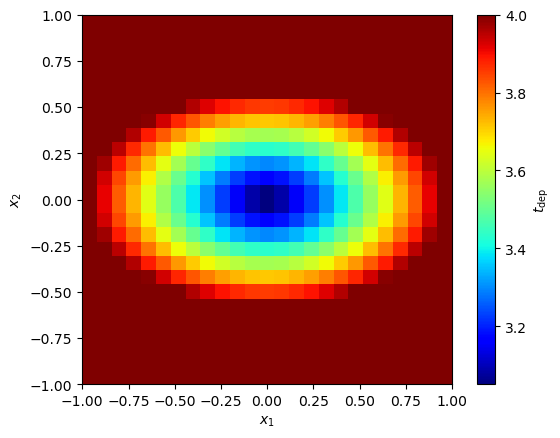

In [37]:
disk1.set_t_dep(q=0.6,
                alpha=1.1,
                t_dep_in=3.,
                t_dep_out=4.)
cube.imshow(disk1.t_dep, cmap=plt.cm.jet, colorbar_label='$t_\mathrm{dep}$')

In [38]:
def y(x, x0=0, x1=2, y0=5, y1=-2, alpha=1.):
    delta_x = x1-x0
    delta_y = y1-y0
    return y0 + delta_y * (x/delta_x)**alpha

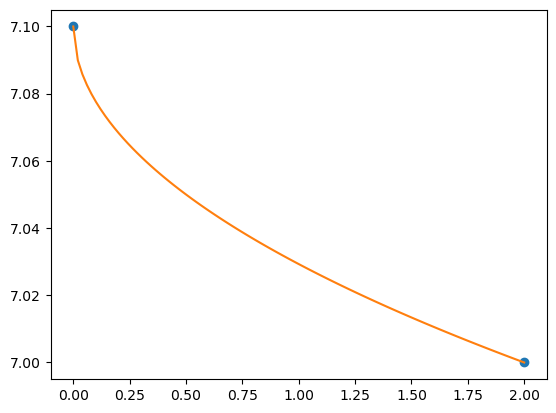

In [39]:
x0=0
x1=2
y0=7.1
y1=7
alpha=0.5

x = np.linspace(x0, x1, 100)
plt.plot([x0,x1], [y0,y1], 'o')
plt.plot(x, y(x, y0=y0, y1=y1, alpha=alpha))

### Age- and Space- depentdent kinemtaics

We spcify age-dependant maps of mean velocities and velocity dispersions. For an SSP of a single age, the LOSVD is Gaussian with this mean and dispersion. The combined LOSVD, for all ages, can be non-Gaussian.

The mean maps take the form of rotating disks with three parameters: an axis ratio `q`, the radius `rmax` and value `vmax` of the maximum velocity. Velocity dispersion maps are by power laws stratified on ellipses, parameterised with axis ratio `q`, power law slope `alpha` and inner and outer values. Each parameter is specified with values for (young, old) stars, and is linearly interpolated for intermediate between these values,

In [ ]:
disk1.set_mu_v(q_lims=(0.5, 0.1),
               rmax_lims=(0.5, 1.1),
               vmax_lims=(250., 100.))

disk1.set_sig_v(q_lims=(0.5, 0.1),
                alpha_lims=(1.6, 1.8),
                sig_v_in_lims=(40., 100.),
                sig_v_out_lims=(20., 70.))

# plot age averaged velocity map
cube.imshow(disk1.get_mean('v_x'), cmap=plt.cm.jet)

## Add a second disk

We can add a second compoent. We will make this younger, rounder, and counter-rotating.

In [ ]:
disk2 = pkm.components.GrowingDisk(cube=cube, rotation=0., center=(0,0))
disk2.set_p_t(lmd=5., phi=0.4)
disk2.set_p_x_t(q_lims=(0.3, 0.7),
                rc_lims=(0.5, 0.6),
                alpha_lims=(0.8, 1.2))
disk2.set_t_dep(q=0.4, alpha=2., t_dep_in=2., t_dep_out=9.)
disk2.set_p_z_tx()
disk2.set_mu_v(q_lims=(0.5, 0.5),
               rmax_lims=(0.8, 0.1),
               vmax_lims=(-180., -150.))
disk2.set_sig_v(q_lims=(0.7, 0.5),
                alpha_lims=(1.6, 1.8),
                sig_v_in_lims=(40., 100.),
                sig_v_out_lims=(20., 70.))
                
# plot age averaged velocity map
cube.imshow(disk2.get_mean('v_x'), cmap=plt.cm.jet)

## Add a stream component

In [ ]:
stream = pkm.components.Stream(cube=cube, rotation=0., center=(0.,0))
stream.set_p_t(lmd=15., phi=0.3)
stream.set_p_x_t(
    theta_lims=[-np.pi/3., 0.75*np.pi],
    mu_r_lims=[0.4,0.8],
    sig=0.06)
stream.set_t_dep(t_dep=5.)
stream.set_p_z_tx()
stream.set_mu_v(mu_v_lims=[-80,100])
stream.set_sig_v(sig_v=110.)

# plot mean v map of stream, masked where density is low
mean_v_map = stream.get_mean('v_x')
stream_density = stream.get_p('x')
tmp = mean_v_map
tmp[stream_density < 0.1] = -np.inf
cube.imshow(tmp, cmap=plt.cm.jet)


## Combine the components

Combine the disks and stream to create a mixture model for the galaxy, then evaluate the datacube,

In [ ]:
galaxy = pkm.components.Mixture(
    cube=cube,
    component_list=[disk1, disk2, stream],
    weights=[0.65, 0.25, 0.1])

for cmp in galaxy.component_list:
    cmp.evaluate_ybar()
galaxy.evaluate_ybar()

# plot spectrum in spaxel 5,6
lmd = np.exp(cube.ssps.w)
plt.plot(lmd, galaxy.ybar[:,5,6])
plt.gca().set_xlabel('Wavelength')

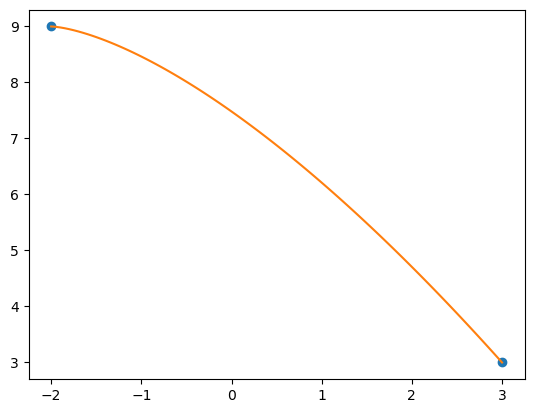

In [16]:
n = 100
x0 = -2
x1 = 3
y0 = 9.
y1 = 3.
alpha = 1.5
delta_y = y1 - y0
delta_x = x1 - x0
x = np.linspace(x0, x1, n)
y = y0 + delta_y*((x-x0)/delta_x)**alpha

plt.plot([x0,x1], [y0,y1], 'o')
plt.plot(x, y, '-')


In [40]:
q = disk1.linear_interpolate_t(*[0.1,0.3])

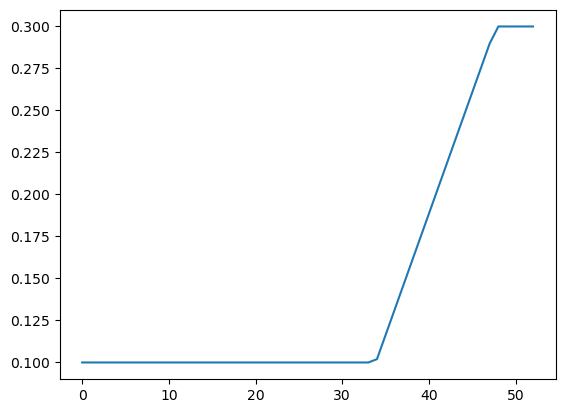

In [41]:
plt.plot(q)

In [42]:
cube.get_variable_values('t')

array([ 0.03  ,  0.04  ,  0.05  ,  0.06  ,  0.07  ,  0.08  ,  0.09  ,
        0.11  ,  0.15  ,  0.2   ,  0.25  ,  0.3   ,  0.35  ,  0.4   ,
        0.45  ,  0.5125,  0.6   ,  0.7   ,  0.8   ,  0.9   ,  1.0375,
        1.25  ,  1.5   ,  1.75  ,  2.    ,  2.25  ,  2.5   ,  2.75  ,
        3.    ,  3.25  ,  3.5   ,  3.75  ,  4.0625,  4.5   ,  5.    ,
        5.5   ,  6.    ,  6.5   ,  7.    ,  7.5   ,  8.    ,  8.5   ,
        9.    ,  9.5   , 10.    , 10.5   , 11.    , 11.5   , 12.    ,
       12.5   , 13.    , 13.5   , 14.    ])

In [47]:
help(pkm.components.Stream)

Help on class Stream in module popkinmocks.components.stream:

class Stream(popkinmocks.components.parametric.ParametricComponent)
 |  Stream(cube=None, center=(0, 0), rotation=0.0)
 |  
 |  Stream with age-independent kinematics and spatially-uniform enrichment
 |  
 |  The mass-weighted density factorises as
 |  p(t,x,v,z) = p(t) p(x|t) p(v|t,x) p(z|t,x), where:
 |  - p(t) : beta distribution (see `set_p_t`),
 |  - p(x|t) = p(x): a curved line with constant thickness (see `set_p_x`),
 |  - p(v|t,x) = p(v|x) = Normal(v ; mu_v(x), sig_v(x)) where mean varies along
 |  stream (see `set_mu_v`) and dispersion is constant (see `set_sig_v`)
 |  - p(z|t,x) = p(z|t) = Normal(z ; mu_z(t, t_dep), sig_z(t, t_dep)) i.e.
 |  chemical enrichment depends on a constant depletion timescale t_dep (see
 |  `set_t_dep`). The functions mu_z(t,t_dep) and sig_z(t,t_dep) are from
 |  equations 3-10 of Zhu et al. 20,
 |  https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1579Z/abstract
 |  
 |  Args:
 |      cub

In [50]:
stream = pkm.components.Stream(cube=cube)

In [51]:
help(stream.set_p_x_t)

Help on method set_p_x_t in module popkinmocks.components.stream:

set_p_x_t(theta_lims=[0.0, 1.5707963267948966], mu_r_lims=[0.7, 0.1], sig=0.03, nsmp=75) method of popkinmocks.components.stream.Stream instance
    Define the stream track p(x)
    
    Defined in polar co-ordinates (theta,r). Stream extends between angles
    `theta_lims` between radii in `mu_r_lims`. Density is constant with
    varying theta. The track has a constant width on the sky, `sig`.
    
    Args:
        theta_lims: (start, end) values of stream angle in radians. Must be
        in -pi to pi. To cross negative x-axis, set non-zero rotation when
        instantiating the stream component.
        mu_r_lims: (start, end) values of stream distance from center.
        sig (float): stream thickness.
        nsmp (int): number of points to sample the angle theta (increase if
            stream looks discretised.
    
    Returns:
        type: Description of returned object.



In [52]:
stream.set_t_dep(7.)

In [53]:
help(stream.set_mu_v)

Help on method set_mu_v in module popkinmocks.components.stream:

set_mu_v(mu_v_lims=[-100, 100]) method of popkinmocks.components.stream.Stream instance
    Set mean velocity linearly varying with stream angle
    
    Args:
        mu_v_lims: (start, end) values of stream velocity



In [54]:
help(pkm.components.Mixture)

Help on class Mixture in module popkinmocks.components.mixture:

class Mixture(popkinmocks.components.base.Component)
 |  Mixture(cube=None, component_list=None, weights=None)
 |  
 |  A mixture component
 |  
 |  The mass-weighted density is a mixture, i.e.
 |  p(t,x,v,z) = sum_i w_i p_i(t,v,x,z)
 |  where w_i >= 0 and sum_i w_i = 1.
 |  
 |  Args:
 |      cube: a pkm.mock_cube.mockCube.
 |      component_list (list): a list of `pkm.component` objects
 |      weights (array): weights, must be non-negative and sum-to-one, and same
 |          length as `component_list`
 |  
 |  Method resolution order:
 |      Mixture
 |      popkinmocks.components.base.Component
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cube=None, component_list=None, weights=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  evaluate_ybar(self)
 |      Evaluate the datacube for this component
 |      
 |      Evaluate the integral
 |      ybar(x,

In [55]:
help(pkm.components.Component)

Help on class Component in module popkinmocks.components.base:

class Component(builtins.object)
 |  Component(cube=None, log_p_tvxz=None)
 |  
 |  A galaxy component specified by the (log) joint density p(t,x,v,z)
 |  
 |  Sub-classes of `Component` correspond to specific choices of p(t,x,v,z).
 |  Main methods are `get_p` to evaluate probability functions and `get_{X}`
 |  for `X` in [`mean`, variance`, `skewness`, `kurtosis`] to evaluate moments.
 |  
 |  Args:
 |      cube: a pkm.mock_cube.mockCube.
 |      log_p_txvz (array): 5D array of natural log of mass-weighted probabilty
 |          density p(t,x1,x2,v,z)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cube=None, log_p_tvxz=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  evaluate_ybar(self)
 |      Evaluate the datacube for this component
 |      
 |      Evaluate the integral
 |      ybar(x, omega) = int_{-inf}^{inf} s(omega-v ; t,z) P(t,v,x,z) dv dt dz
 |      where
 |      omeg

In [58]:
help(disk1.get_p)

Help on method get_p in module popkinmocks.components.base:

get_p(which_dist, density=True, light_weighted=False) method of popkinmocks.components.growing_disk.GrowingDisk instance
    Evaluate population-kinematic distributions for this component
    
    Evaluate marginal or conditional distributions over stellar age t, 2D
    position x, velocity v and metallicity z. The argument `which_dist`
    specifies which distribution to evaluate, where an underscore (if
    present) represents conditioning e.g.
    - `which_dist = 'tv'` --> p(t,v),
    - `which_dist = 'tz_x'` --> p(t,z|x) etc ...
    Variables in `which_dist` must be provided in alphabetical order (on
    either side of the underscore if present).
    
    Args:
        which_dist (string): which density to evaluate
        density (bool): whether to return probabilty density (True) or the
            volume-element weighted probabilty (False)
        light_weighted (bool): whether to return light-weighted (True) or
       

In [59]:
disk1.get_log_p('tvxz')

AttributeError: 'GrowingDisk' object has no attribute 'mu_v'